In [18]:
import matplotlib
matplotlib.use('nbagg')
print(matplotlib.get_backend())


nbAgg


In [19]:
import os
import matplotlib.pyplot as plt
from os import listdir
import random
import numpy as np
import cv2 as cv

loading data from directory

In [20]:
#dataset_location = 'C:/Users/sushl/Downloads/Visual-Odometry-master/Visual-Odometry-master/KITTI_sample/images'
dataset_location = 'C:/Users/sushl/Desktop/visual odometry/adc'
#dataset_location = 'C:/Users/sushl/Downloads/Archives/data_odometry_gray/dataset/sequences/07/image_0'
L = os.listdir(dataset_location)
L.sort()
print(L)

['iv_video_images00001.png', 'iv_video_images00002.png', 'iv_video_images00003.png', 'iv_video_images00004.png', 'iv_video_images00005.png', 'iv_video_images00006.png', 'iv_video_images00007.png', 'iv_video_images00008.png', 'iv_video_images00009.png', 'iv_video_images00010.png', 'iv_video_images00011.png', 'iv_video_images00012.png', 'iv_video_images00013.png', 'iv_video_images00014.png', 'iv_video_images00015.png', 'iv_video_images00016.png', 'iv_video_images00017.png', 'iv_video_images00018.png', 'iv_video_images00019.png', 'iv_video_images00020.png', 'iv_video_images00021.png', 'iv_video_images00022.png', 'iv_video_images00023.png', 'iv_video_images00024.png', 'iv_video_images00025.png', 'iv_video_images00026.png', 'iv_video_images00027.png', 'iv_video_images00028.png', 'iv_video_images00029.png', 'iv_video_images00030.png', 'iv_video_images00031.png', 'iv_video_images00032.png', 'iv_video_images00033.png', 'iv_video_images00034.png', 'iv_video_images00035.png', 'iv_video_images000

ground_truth

In [21]:
#ground_truth = np.loadtxt('C:/Users/sushl/Downloads/Visual-Odometry-master/Visual-Odometry-master/KITTI_sample/poses.txt',delimiter = ' ')
#ground_truth = np.loadtxt('C:/Users/sushl/Downloads/Archives/data_odometry_poses/dataset/poses/05.txt',delimiter = ' ')
ground_truth = np.loadtxt('C:/Users/sushl/Downloads/Archives/data_odometry_poses/dataset/poses/07.txt',delimiter = ' ')
ground_truth.shape
gx = ground_truth[:150,3]
gz = ground_truth[:150,11]

calibration matrix

In [44]:
"""
k =np.array([[7.188560000000e+02, 0.000000000000e+00, 6.071928000000e+02], 
             [0.000000000000e+00, 7.188560000000e+02, 1.852157000000e+02], 
             [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]])

"""
k = np.array([[518.56666108, 0., 329.45801792],
    [0., 518.80466479, 237.05589955],
    [  0., 0., 1.]])


In [45]:
sift = cv.SIFT_create()
bf = cv.BFMatcher()

function for triangulating Points

In [46]:
def point3D(k,R,t,pts1,pts2):
    rt = np.zeros((3,4))
    rt[:3,:3] = np.identity(3)
    projMatr1 = k@rt
    rt2 = np.zeros((3,4))
    rt2[:3,:3] = R
    rt2[:,3] = t.reshape((3))
    projMatr2 = k@rt2
    points4D = cv.triangulatePoints(projMatr1,projMatr2,pts1 ,pts2)
    points3D = points4D / points4D[3,:]
    return points3D.T

function for calculating scale

by finding distance ratio

In [47]:
def RelativeScale1(last_cloud, new_cloud):
    min_idx = min([new_cloud.shape[0],last_cloud.shape[0]])
    p_Xk = new_cloud[:min_idx]
    Xk = np.roll(p_Xk,shift = -10)
    p_Xk_1 = last_cloud[:min_idx]
    Xk_1 = np.roll(p_Xk_1,shift = -10)
    d_ratio = (np.linalg.norm(p_Xk_1 - Xk_1,axis = -1))/(np.linalg.norm(p_Xk - Xk,axis = -1))

    return np.median(d_ratio)

by projecting old 3d cloud on to the new one

In [48]:
def RelativeScale2(last_cloud, new_cloud,R,t):
    min_idx = min([new_cloud.shape[0],last_cloud.shape[0]])
    p_Xk = new_cloud[:min_idx,:3]
    p_Xk_1 = last_cloud[:min_idx,:3]
    s = np.linalg.inv(p_Xk_1@p_Xk_1.T)@p_Xk_1@R.T@(p_Xk.T - t)
    return abs(np.median(s))

calculating trajectory by calculating scale

In [49]:

scale = 1
trans= {}
rot = {}

for a in range(len(L)-1):
    #start2 = timeit.timeit()
    sift = cv.SIFT_create()
    bf = cv.BFMatcher()

    img1 = cv.imread(dataset_location +'/'+ L[a],cv.IMREAD_GRAYSCALE)
    img2 = cv.imread(dataset_location +'/'+ L[a+1],cv.IMREAD_GRAYSCALE)
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    matches = bf.knnMatch(des1,des2,k=2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    src_p = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_p=np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    
    pts1 = np.float32(src_p)
    pts2 = np.float32(dst_p)

    R = []
    t = []
    
    #F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
    F,mask = cv.findFundamentalMat(pts1, pts2,cv.FM_RANSAC ,0.4,0.9,mask=None)
    E = k.T@F@k
        
    retval, R, t, mask = cv.recoverPose(E, pts1, pts2, k)
    
    if a == 0:
        trans[a] = -1*R@t
        rot[a] = R
    else:
        rot[a] = rot[a-1]@R
        trans[a] = trans[a-1] - rot[a]@t



In [50]:
translations1 = []
translations1.append(np.zeros((3,1)))
rotations1 = []
rotations1.append(np.identity(3))
scale1 = []
pointcloud = []
error_set = []

for a in range(len(L)-1):
    old_cloud = pointcloud
    img1 = cv.imread(dataset_location +'/'+ L[a],cv.IMREAD_GRAYSCALE)
    img2 = cv.imread(dataset_location +'/'+ L[a+1],cv.IMREAD_GRAYSCALE)
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    matches = bf.knnMatch(des1,des2,k=2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    src_p = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_p=np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    pts1 = np.float32(src_p)
    pts2 = np.float32(dst_p)

    R = []
    t = []
    #F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
    F,mask = cv.findFundamentalMat(pts1, pts2,cv.FM_RANSAC ,0.4,0.9,mask=None)
    E = k.T@F@k
    #E, mask = cv.findEssentialMat(pts1,pts2,k,cv.RANSAC, prob = 0.999,threshold = 0.4,mask=None)
    #print(pts1)
    retval, R, t, mask = cv.recoverPose(E, pts1, pts2, k)
    if a == 0:
        #pc = point3D(k,R,t,pts1,pts2)
        #pc = pc[:,:3]
        #retval, rvec, t, inliers = cv.solvePnPRansac(pc,pts2, k, (0,0,0,0),useExtrinsicGuess = True ,iterationsCount = 200,reprojectionError = 8.0,confidence = 0.50,flags = 1)
        #R,Jec = cv.Rodrigues(rvec)
        pointcloud = point3D(k,R,t,pts1,pts2)
        translations1.append(t)
        print(t)
        rotations1.append(R)
        pointcloud = pointcloud[:,:3]
        p3d = np.ones((4,pointcloud.shape[0]))
        p3d[:3,:] = pointcloud.T
        projection_mat = np.zeros((3,4))
        projection_mat[:3,:3] = rotations1[a]
        projection_mat[:,3] = translations1[a].reshape((3))
        proj_pt = k@projection_mat@p3d
        proj_pt = proj_pt.T
        proj_pt= proj_pt / proj_pt[:,2].reshape((-1,1))
        proj_pt = proj_pt[:,:2]
        err = proj_pt - pts2.reshape((-1,2))
        norm_err = np.linalg.norm(err, axis=1)
        error_set.append(np.min(norm_err))
        print(a,np.min(norm_err))
        
    elif a == len(L)-1:
        #pc = point3D(k,R,t,pts1,pts2)
        #pc = pc[:,:3]
        #retval, rvec, t, inliers = cv.solvePnPRansac(pc,pts2, k, (0,0,0,0),useExtrinsicGuess = True ,iterationsCount = 200,reprojectionError = 8.0,confidence = 0.90,flags = 1)
        #R,Jec = cv.Rodrigues(rvec)
        pointcloud = point3D(k,R,t,pts1,pts2)
        print(t)
        rotations1.append(rotations1[a]@R)
        s1 = RelativeScale1(old_cloud, pointcloud)
        #s1 = RelativeScale2(old_cloud, pointcloud,rotations[a+1],t)
        scale1.append(s1)
        translations1[a] = translations1[a-1] - s1*rotations1[a]@translations1[a]
        translations1.append(t+ translations1[a])
        pointcloud = pointcloud[:,:3]
        p3d = np.ones((4,pointcloud.shape[0]))
        p3d[:3,:] = pointcloud.T
        projection_mat = np.zeros((3,4))
        projection_mat[:3,:3] = rotations1[a]
        projection_mat[:,3] = translations1[a].reshape((3))
        proj_pt = k@projection_mat@p3d
        proj_pt = proj_pt.T
        proj_pt= proj_pt / proj_pt[:,2].reshape((-1,1))
        proj_pt = proj_pt[:,:2]
        err = proj_pt - pts2.reshape((-1,2))
        norm_err = np.linalg.norm(err, axis=1)
        error_set.append(np.min(norm_err))
        print(a,np.min(norm_err))
        
    else:
        #pc = point3D(k,R,t,pts1,pts2)
        #pc = pc[:,:3]
        #retval, rvec, t, inliers = cv.solvePnPRansac(pc,pts2, k, (0,0,0.001,0),useExtrinsicGuess = True ,iterationsCount = 400,reprojectionError = 1.0,confidence = 0.70,flags = 1)
        #R,Jec = cv.Rodrigues(rvec)
        pointcloud = point3D(k,R,t,pts1,pts2)
        print(t)
        rotations1.append(rotations1[a]@R)
        s1 = RelativeScale1(old_cloud, pointcloud)
        #s1 = RelativeScale2(old_cloud, pointcloud,rotations1[a+1],t)
        scale1.append(s1)
        translations1[a] = translations1[a-1] - s1*rotations1[a]@translations1[a]
        translations1.append(t)
        pointcloud = pointcloud[:,:3]
        p3d = np.ones((4,pointcloud.shape[0]))
        p3d[:3,:] = pointcloud.T
        projection_mat = np.zeros((3,4))
        projection_mat[:3,:3] = rotations1[a]
        projection_mat[:,3] = translations1[a].reshape((3))
        proj_pt = k@projection_mat@p3d
        proj_pt = proj_pt.T
        proj_pt= proj_pt / proj_pt[:,2].reshape((-1,1))
        proj_pt = proj_pt[:,:2]
        err = proj_pt - pts2.reshape((-1,2))
        norm_err = np.linalg.norm(err, axis=1)
        error_set.append(np.min(norm_err))
        print(a,np.min(norm_err))

[[-0.12464223]
 [ 0.13664275]
 [-0.98274772]]
0 0.1624053217801453
[[-0.416072  ]
 [ 0.10320741]
 [-0.90345577]]
1 3.329344077595901
[[ 0.1680741 ]
 [-0.07126159]
 [ 0.98319524]]
2 1.2657973034045975
[[-0.99715258]
 [-0.07464508]
 [ 0.01071613]]
3 6.118773180791377
[[-0.05243436]
 [-0.07952488]
 [ 0.99545288]]
4 0.507683644646479
[[-0.1463621 ]
 [ 0.24504477]
 [-0.95840033]]
5 0.1955146953424874
[[-0.20233472]
 [ 0.11995182]
 [-0.9719425 ]]
6 0.5716681636193326
[[-0.9304051]
 [-0.0206858]
 [ 0.3659487]]
7 1.9556462229160119
[[ 0.71607076]
 [ 0.13925016]
 [-0.68399712]]
8 5.0571029987183
[[ 0.19534084]
 [ 0.10689322]
 [-0.97489271]]
9 5.127204619717586
[[0.61478684]
 [0.15133674]
 [0.77403768]]
10 3.951666654220626
[[ 0.09654582]
 [-0.08115061]
 [ 0.99201486]]
11 7.434505799596156
[[ 0.43061251]
 [-0.23115063]
 [-0.87243467]]
12 7.789948796884472
[[ 0.1071293 ]
 [ 0.11880437]
 [-0.98712149]]
13 5.441771369012279
[[-0.2269256 ]
 [-0.20711158]
 [ 0.95163521]]
14 5.3346535325024185
[[-0.09

[[-0.27162988]
 [-0.09170815]
 [-0.95802235]]
122 20.52815006542191
[[ 0.18930144]
 [ 0.06201419]
 [-0.97995878]]
123 39.20019155552219
[[ 0.63263364]
 [-0.04561643]
 [ 0.7731066 ]]
124 60.23923764132451
[[0.15443074]
 [0.25263858]
 [0.955157  ]]
125 49.5874996752863
[[-0.54603147]
 [-0.24109654]
 [-0.80232294]]
126 7.257015544673476
[[-0.74635413]
 [ 0.15161877]
 [-0.64804881]]
127 12.535676225464528
[[-0.05617536]
 [ 0.02409025]
 [ 0.99813025]]
128 8.556983263399001
[[ 0.21893102]
 [-0.09312873]
 [ 0.97128587]]
129 12.078503841544102
[[ 0.05544763]
 [-0.01089713]
 [ 0.99840213]]
130 49.26807864465563
[[-0.16836202]
 [-0.1347433 ]
 [-0.97647247]]
131 20.696370601119266
[[-0.08340649]
 [-0.24789233]
 [ 0.96519052]]
132 22.608775988864714
[[-0.27529384]
 [ 0.39089877]
 [-0.87830032]]
133 13.38076080116769
[[-0.10285235]
 [-0.02624716]
 [ 0.99435028]]
134 15.224695073208666
[[-0.05004226]
 [-0.02205384]
 [-0.99850358]]
135 6.5712228526955885
[[ 0.21584403]
 [ 0.01489325]
 [-0.97631427]]


[[0.3183752 ]
 [0.01588484]
 [0.94783169]]
243 48.86684151912725
[[0.29080154]
 [0.07176656]
 [0.95408806]]
244 38.79227670456824
[[ 0.71555254]
 [-0.05723795]
 [ 0.69621001]]
245 29.66173020892725
[[ 0.1044872 ]
 [ 0.25828264]
 [-0.96040226]]
246 30.73861218111813
[[ 0.75546916]
 [ 0.64494089]
 [-0.11540187]]
247 16.094633489443407
[[ 0.55284005]
 [-0.35315353]
 [ 0.75475192]]
248 28.448765182941628
[[ 0.48943496]
 [ 0.25521327]
 [-0.83385826]]
249 9.423966388611099
[[ 0.53831511]
 [ 0.06976676]
 [-0.83985084]]
250 33.79541534511715
[[0.54093253]
 [0.05697301]
 [0.83913412]]
251 40.69781472080731
[[ 0.47736999]
 [-0.00450261]
 [ 0.87869086]]
252 29.724441865210373
[[ 0.72266097]
 [-0.02730996]
 [-0.69066293]]
253 29.90149364035119
[[-0.00177063]
 [ 0.100035  ]
 [-0.99498234]]
254 35.263744054879005
[[ 0.20247804]
 [ 0.36452538]
 [-0.90891358]]
255 23.338291056256946
[[ 0.21460634]
 [-0.03516508]
 [-0.97606738]]
256 30.683986353075017
[[0.43048026]
 [0.0173351 ]
 [0.90243351]]
257 77.0

[[-0.45315193]
 [-0.3494598 ]
 [ 0.82007998]]
364 127.95273281799349
[[ 0.66597845]
 [ 0.0190229 ]
 [-0.74572839]]
365 60.73567107435722
[[ 0.23779459]
 [-0.00548977]
 [-0.97129995]]
366 47.23396731569074
[[-0.13859909]
 [-0.03525216]
 [-0.98972096]]
367 62.93871155549998
[[-0.94113937]
 [-0.30406117]
 [ 0.14766002]]
368 119.09001586382887
[[ 0.65984104]
 [-0.046858  ]
 [-0.74994275]]
369 30.162590277528746
[[-0.17277468]
 [ 0.01280972]
 [-0.98487807]]
370 21.954302324523724
[[-0.28950795]
 [ 0.04805474]
 [-0.95596856]]
371 61.50335003738518
[[0.93900618]
 [0.19616184]
 [0.28246757]]
372 38.94857381859721
[[-0.43025716]
 [-0.14724554]
 [-0.89061638]]
373 55.50281288566684
[[-0.17787426]
 [ 0.04311728]
 [-0.98310816]]
374 88.85241660006874
[[ 0.89218423]
 [ 0.25293406]
 [-0.37420804]]
375 67.65721250766913
[[ 0.29772424]
 [ 0.02919841]
 [-0.95420529]]
376 17.37654684626792
[[-0.38955108]
 [-0.1092216 ]
 [-0.91450566]]
377 46.655365882800936
[[0.19208343]
 [0.032323  ]
 [0.98084615]]
378

[[ 0.22021853]
 [-0.15097674]
 [-0.96369592]]
484 9.19880593223456
[[-0.53358246]
 [-0.46354296]
 [ 0.70740207]]
485 127.80057649353624
[[-0.47767943]
 [-0.09156761]
 [ 0.87374924]]
486 23.362080863517683
[[-0.90696095]
 [-0.41804997]
 [-0.0515369 ]]
487 66.44234597247265
[[-0.0705074 ]
 [-0.16401014]
 [ 0.98393566]]
488 23.175850074585583
[[ 0.0158774 ]
 [-0.13656682]
 [-0.99050362]]
489 7.830442461178256
[[-0.49282386]
 [ 0.01707274]
 [ 0.86996159]]
490 4.089503642892713
[[ 0.95982945]
 [-0.11410119]
 [-0.2563364 ]]
491 87.14994810457195
[[ 0.57676811]
 [ 0.09770415]
 [-0.81104404]]
492 53.85737528715156
[[-0.50916114]
 [ 0.20442834]
 [ 0.83604066]]
493 28.423661055186432
[[ 0.0766981 ]
 [-0.03915497]
 [-0.99628524]]
494 64.79232040052646
[[-0.92515693]
 [-0.34301596]
 [ 0.16255679]]
495 123.48836989198024
[[-0.88594945]
 [ 0.05346921]
 [ 0.46068929]]
496 11.612610056715546
[[-0.17012945]
 [-0.32749215]
 [-0.92941103]]
497 15.759522054002737
[[0.28818357]
 [0.37427449]
 [0.88140163]]

<IPython.core.display.Javascript object>


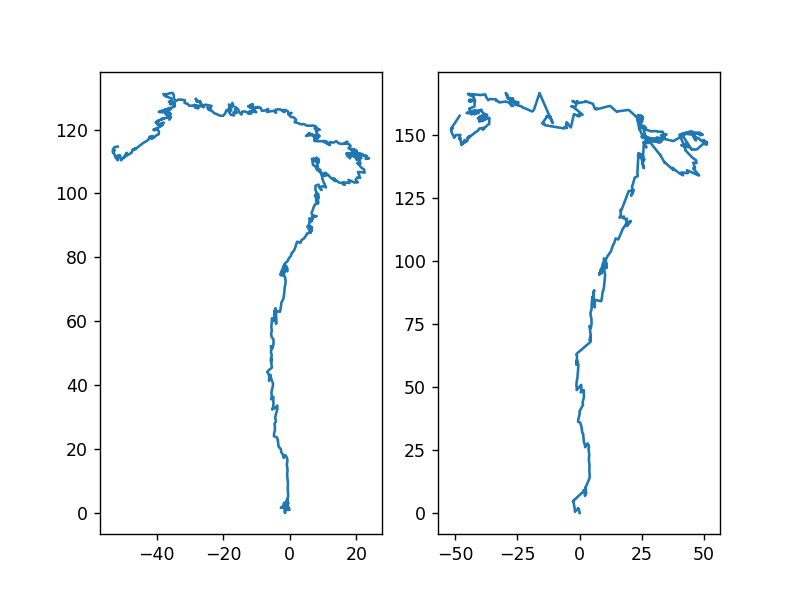

In [54]:

x0 = []
y0 = []

for i in trans:
    y0.append(trans[i][2])
    x0.append(-1*trans[i][0])

x1 = []
y1 = []

for i in range(len(translations1)-1):
    y1.append(translations1[i][2])
    x1.append(-1*translations1[i][0])

fig,axes = plt.subplots(ncols = 2)
axes[0].plot(x0,y0,label = 'with scale = 1')
#axes[0].plot(gx, gz,color = 'red',label = 'ground_truth')
axes[1].plot(x1, y1,label = 'scale using dist ratio')
#axes[1].plot(gx, gz,color = 'red',label = 'ground_truth')

#axes[1].legend()
#axes[0].legend()

plt.show()


<IPython.core.display.Javascript object>


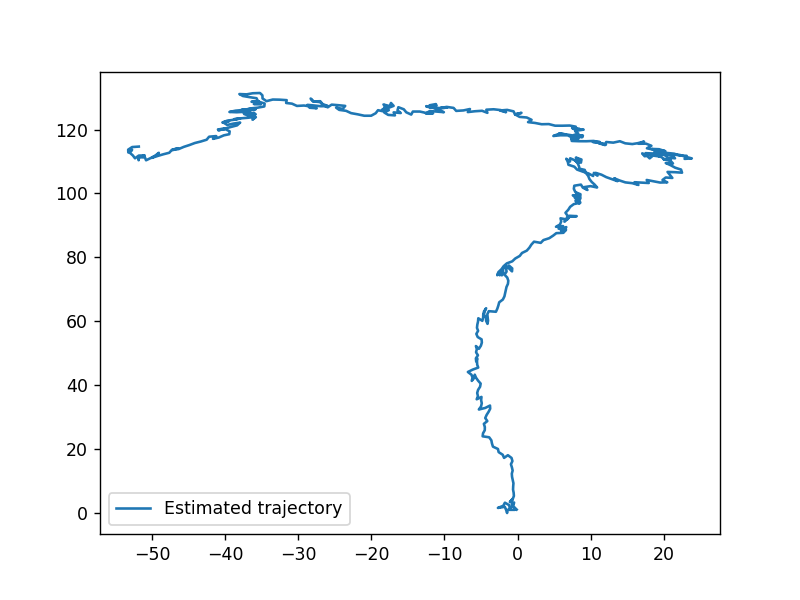

In [55]:
x0 = []
y0 = []
for i in range(len(translations1)-1):
    y0.append(trans[i][2])
    x0.append(-1*trans[i][0])
fig,axes = plt.subplots()
axes.plot(x0,y0,label = 'Estimated trajectory')
#axes.plot(gx, gz,color = 'red',label = 'Ground truth')
axes.legend()
plt.show()

In [15]:
print(translations1)

[array([[0.],
       [0.],
       [0.]]), array([[-0.2442862 ],
       [ 0.01068157],
       [ 0.08257463]]), array([[-5.44280535],
       [ 0.80920679],
       [13.54135168]]), array([[-5.42654874],
       [ 0.80864017],
       [13.51456644]]), array([[-4.92292181],
       [ 0.82215755],
       [12.6216006 ]]), array([[-4.61839009],
       [ 0.82542405],
       [12.03777332]]), array([[-4.24073219],
       [ 0.69450559],
       [10.4301245 ]]), array([[-4.07863365],
       [ 0.67387521],
       [10.04759539]]), array([[-2.30715664],
       [ 0.39463484],
       [ 4.48537947]]), array([[-2.67379274],
       [ 0.33964342],
       [ 4.59565252]]), array([[-3.03108937],
       [ 0.33211923],
       [ 5.2053661 ]]), array([[-2.74913119],
       [ 0.44182487],
       [ 4.75277098]]), array([[-8.66639671],
       [ 2.058586  ],
       [24.77739305]]), array([[-8.89699044],
       [ 2.09706708],
       [25.5296469 ]]), array([[-8.79009254],
       [ 2.09214546],
       [25.3561716 ]]), array(

<IPython.core.display.Javascript object>


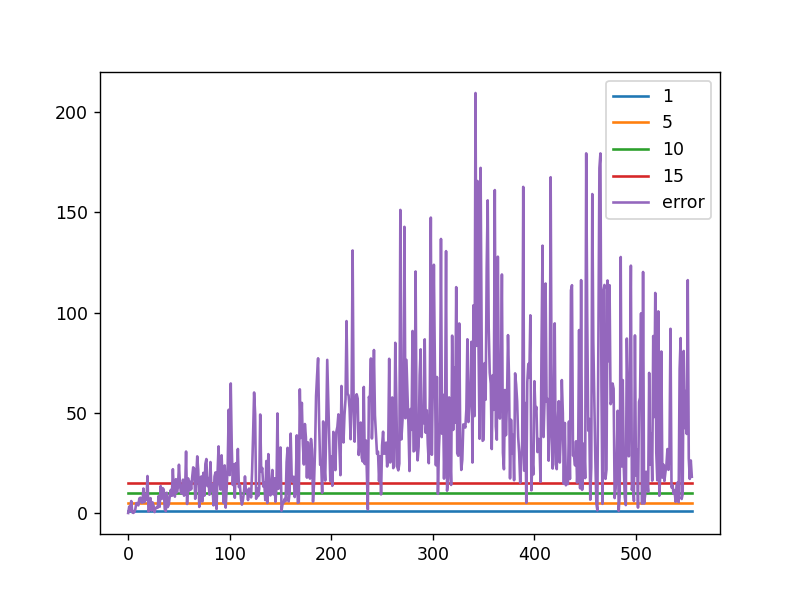

In [56]:
x0 = []
x1 = []
x2 = []
y0 = []
y1 = []
y2 = []
for i in range(len(error_set)-1):
    y0.append(error_set[i])
    x0.append(i)
    y1.append(1)
    y2.append(5)
    x1.append(10)
    x2.append(15)
    
fig,axes = plt.subplots()
axes.plot(x0, y1,label = '1')
axes.plot(x0, y2,label = '5')
axes.plot(x0, x1,label = '10')
axes.plot(x0, x2,label = '15')
axes.plot(x0, y0,label = 'error')
axes.legend()

plt.show()

In [17]:
img1 = cv.imread(dataset_location +'/'+ L[0],cv.IMREAD_GRAYSCALE)

In [18]:
img1.shape

(480, 640)